# <center> Ансамбли решающих деревьев</center>

### План

- Теория
    - ансамбли решающих деревьев
    - бутстреп
    - бэггинг
- Random Forest
    - Сравнение с бэггингом и решающим деревом для задачи регрессии
    - Сравнение с бэггингом и решающим деревом для задачи классификации
    - Прогнозирование оттока клиентов мобильного оператора с помощью Random Forest
- Отбор признаков с помощью RandomForest
    - Задача про сбок фидбека от постояльцев отелей
- Бонус: классификация вина по качеству с помощью бэггинга и RandomForest
    
## <center> Часть 1. Теория </center>

### Ансамбли

Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784). Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных. 

Давайте рассмотрим ещё один пример ансамблей — "Мудрость толпы". Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян. 
Их собралось около 800 человек и они пытались угадать вес быка, который стоял перед ними. Его вес составлял 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.
Эту идею уменьшения ошибки применили и в машинном обучении.


### Бутстрэп

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Бэггинг основан на статистическом методе бутстрэппинга, который позволяет оценивать многие статистики сложных моделей.

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

![image](bootstrap.jpg)



### Бэггинг


Как работае бэггинг? Пусть имеется обучающая выборка $\large X$. С помощью бутстрэпа сгенерируем из неё выборки $\large X_1, \dots, X_M$. Теперь на каждой выборке обучим свой классификатор $\large a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. Эту схему можно представить картинкой ниже.

<img src="bagging.png" alt="image"/>


В библиотеке `scikit-learn` есть реализация `BaggingRegressor` и `BaggingClassifier`, которая позволяет использовать большинство других алгоритмов "внутри". Рассмотрим на практике как работает бэггинг и сравним его с деревом решений, воспользуясь примером из [документации](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).


Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению существенно различных базовых классификаторов. В случае больших выборок обычно генерируют подвыборки существенно меньшей длины.


### Почему хорошими базовыми алгоритмами для бэггинга являются именно деревья?

## <center> Часть 2. Случайный лес</center>

Напоминание из лекции: случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

### Сравнение с деревом решений и бэггингом

#### Решение задачи регрессии

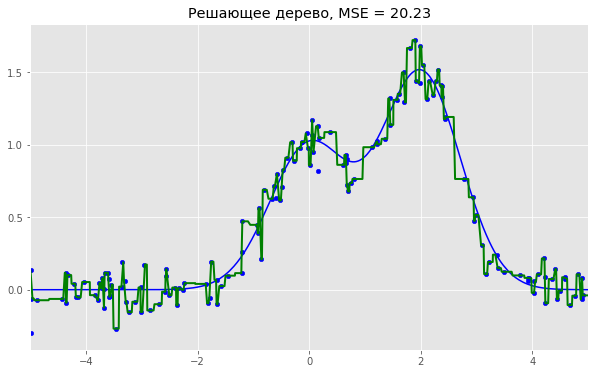

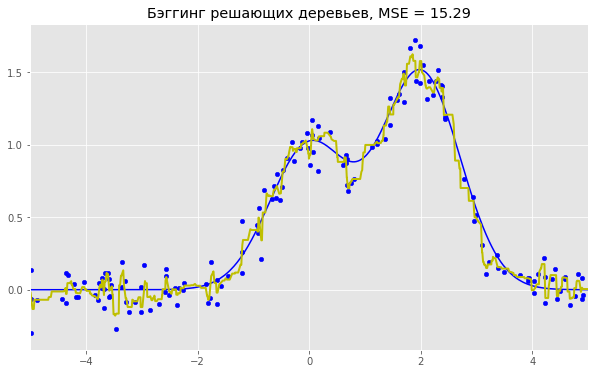

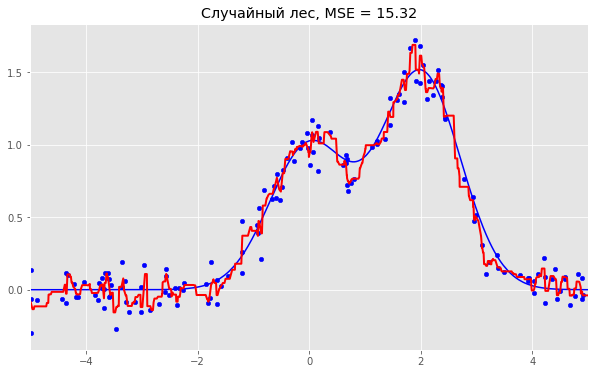

In [8]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

     
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

# формируем обучающую и тестовую выборку
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

# построение графика
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Решающее дерево, MSE = %.2f" 
          % np.sum((y_test - d_predict) ** 2))

# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

# построение графика
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Бэггинг решающих деревьев, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2));

# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

# построение графика
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Случайный лес, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

Как мы видим из графиков и значений ошибки MSE, случайный лес из 10 деревьев дает лучший результат, чем одно дерево или бэггинг из 10 деревьев решений. Основное различие случайного леса и бэггинга на деревьях решений заключается в том, что в случайном лесе из случайного числа выбирается случайное подмножество признаков, и лучший признак для разделения узла определяется из подвыборки признаков, в отличие от бэггинга, где все функции рассматриваются для разделения в узле.

Также можно увидеть преимущество случайного леса и бэггинга в задачах классификации.



#### Решение задачи классификации

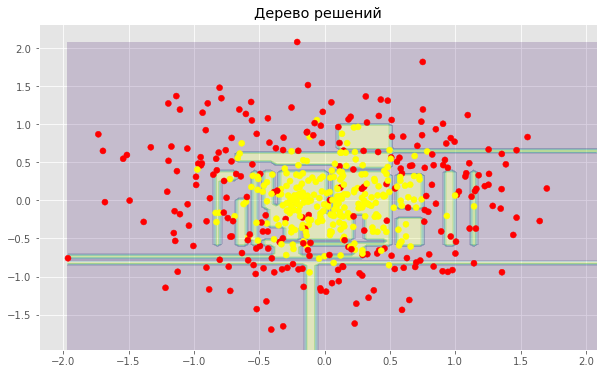

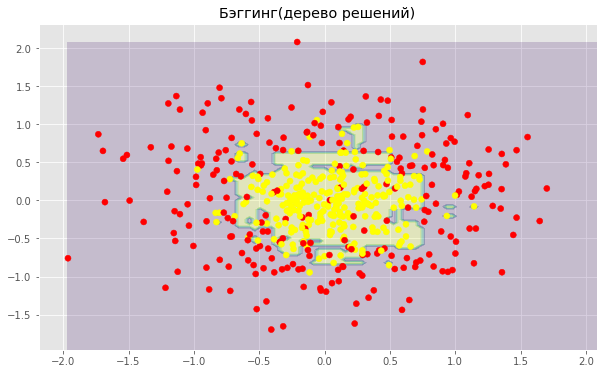

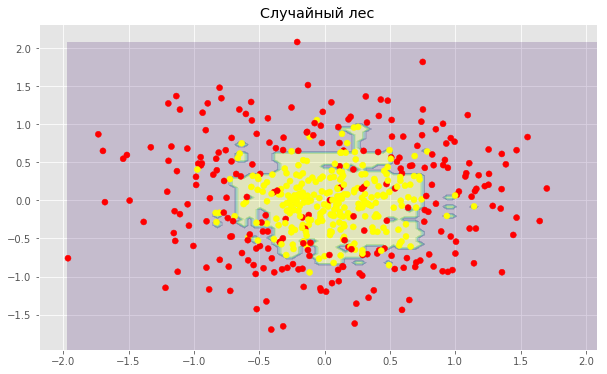

In [9]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

# решащее дерево
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

# построение графика
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево решений")
plt.show()

# Бэггинг
b_dtree = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

# построение графика
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Бэггинг(дерево решений)")
plt.show()

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

# построение графика
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

На рисунках выше видно, что разделяющая граница дерева решений очень «рваная» и на ней много острых углов, что говорит о переобучении и слабой обобщающей способности. В то время как у бэггинга и случайного леса граница достаточно сглаженная и практически нет признаков переобучения.

Давайте теперь попробуем разобраться с параметрами, с помощью подбора которых мы cможем увеличить долю правильных ответов.

### Параметры


Метод случайного леса реализован в библиотеке машинного обучения [scikit-learn](http://scikit-learn.org/stable/) двумя классами RandomForestClassifier и RandomForestRegressor.

Далее рассмотрим несколько параметров, на которые в первую очередь стоит обратить внимание при построении модели:
- n_estimators — число деревьев в "лесу"
- criterion — критерий для разбиения выборки в вершине
- max_features — число признаков, по которым ищется разбиение
- min_samples_leaf — минимальное число объектов в листе
- max_depth — максимальная глубина дерева

**Рассмотрим применение случайного леса в реальной задаче**


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Загружаем данные
df = pd.read_csv("telecom_churn.csv")

# Выбираем сначала только колонки с числовым типом данных
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Разделяем на признаки и объекты
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Инициализируем стратифицированную разбивку нашего датасета для валидации
# your code here

# Инициализируем наш классификатор с дефолтными параметрами
# your code here

# Обучаем на тренировочном датасете
# your code here

# Оцениваем точность на тестовом датасете
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

NameError: name 'results' is not defined

Получили точность 91.21%, теперь попробуем улучшить этот результат и посмотреть, как ведут себя кривые обучения при изменении основных параметров.

Будем подбирать количество деревьев:

In [7]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = [] # точность на тренировочном датасете
test_acc = [] # точность на тестовом датасете
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100] # количество деревьев, которое мы хотим попробовать

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    # инициализируем лес и задаем параметры
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        # делим выборку на обучающую и тестовую выборку
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # обучаем случайный лес
        # your code here
        
        # считаем точность на трейне и тесте
        temp_train_acc.append(# your code here)
        temp_test_acc.append(# your code here)
        
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

# выводим на печать точность случайного леса с наилучшими выбранными параметрами
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.44% with 50 trees


In [ ]:
# нарисуйте, как менялось качество в зависимости от параметра msx_features

# your code here

В нашем случае оптимальное число признаков — 10, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые обучения в зависимости от изменения основных параметров. Давайте теперь с помощью `GridSearch` найдем оптимальные параметры для нашего примера.



In [ ]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = # your code here
gcv = # your code here
gcv.fit(X, y)

In [ ]:
gcv.best_estimator_, gcv.best_score_

Лучшая точность, который мы смогли достичь с помощью перебора параметров — 92.83% при `'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 3`. 

## <center> Часть 3. Отбор признаков с помощью RandomForest </center>

Рассмотрим результаты анкетирования посетителей хостелов с сайтов Booking.com и TripAdvisor.com. Признаки — средние оценки по разным факторам (перечислены ниже) — персонал, состояние комнат и т.д. Целевой признак — рейтинг хостела на сайте.



Populating the interactive namespace from numpy and matplotlib
Feature ranking:
1. Персонал 0.182757 
2. Цена/качество 0.148373 
3. Состояние общего пространства 0.128296 
4. Дополнительные услуги 0.116604 
5. ССЦ 0.106668 
6. Общие условия и удобства 0.088589 
7. Состояние общей кухни 0.074273 
8. Заезд в хостел и выезд из хостела 0.061521 
9. Бронирование хостела  0.053615 
10. Состояние комнаты 0.039305 


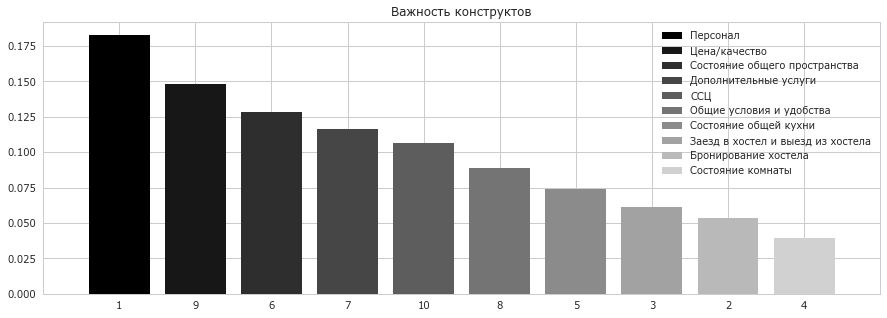

In [54]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

hostel_data = pd.read_csv("hostel_factors.csv")
features = {
    "f1":u"Персонал",
    "f2":u"Бронирование хостела ",
    "f3":u"Заезд в хостел и выезд из хостела",
    "f4":u"Состояние комнаты",
    "f5":u"Состояние общей кухни",
    "f6":u"Состояние общего пространства",
    "f7":u"Дополнительные услуги",
    "f8":u"Общие условия и удобства",
    "f9":u"Цена/качество",
    "f10":u"ССЦ"
}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(
    range(num_to_plot), 
    importances[indices[:num_to_plot]],
    color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center"
)

ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(
    bars,
    [u''.join(features["f"+str(i)]) for i in feature_indices]
)

На рисунке выше видно, что люди больше всего обращают внимание на персонал и соотношение цена/качество и на основе впечатления от данных вещей пишут свои отзывы. Но разница между этими признаками и менее влиятельными признаками не очень значительная, и выкидывание какого-то признака приведет к уменьшению точности нашей модели. Но даже на основе нашего анализа мы можем дать рекомендации отелям в первую очередь лучше готовить персонал и/или улучшить качество до заявленной цены. 




### Бонус: классификация вина по качеству

Будем работать с популярным датасетом с характеристиками вина. Нужно предсказать качество вина (число от 1 - очень плохое качество, 2 - среднее, 3 - хорошее вино).

<img src='wines_game.png'>

In [10]:
import pandas as pd

# самописная функция для визуализации графиков
from visualize_data import visualize_classification_performance

In [ ]:
data = pd.read_csv('wine.data.txt', header=None, names=[
    'quality_categorical', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'
])

<img src='wine-dataset.jpg'>

In [ ]:
# Split the data into features and target label
quality_raw = data['quality_categorical']
features_raw = data.drop(['quality_categorical'], axis = 1)

Делим выборку на обучающую и тестовую:

In [ ]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_raw, 
    quality_raw, 
    test_size = 0.2, 
    random_state = 17)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Пишем функцию, которая принимает на вход модель и данные, а выдает качество ее работы (будем измерять accuracy и F-меру).

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from time import time

def train_predict_evaluate(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}
    
    start = time()
    learner = learner.fit(# your code here )
    end = time()
    
    results['train_time'] = # your code here
    
    start = time()
    predictions_train = # your code here
    predictions_test = # your code here
    end = time()
    
    results['pred_time'] = # your code here
    
    results['acc_train'] = # your code here
    results['acc_test'] = # your code here
    
    results['f_train'] = fbeta_score(y_train,  predictions_train, beta=0.5, average='micro')
    results['f_test'] = fbeta_score(y_test,  predictions_test, beta=0.5, average='micro')
    
    print('{} trained on {} samples'.format(learner.__class__.__name__, sample_size))
    return results
    

Теперь берем три модели: решающее дерево, бэггинг и случайный лес, сравниваем их между собой. Будем мерять качество отдельно на 1%, 10%, 100% выборки:

In [ ]:
# Import any three supervised learning classification models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Initialize the three models
clf_A = BaggingClassifier()
clf_B = DecisionTreeClassifier(max_depth=None, random_state=None)
clf_C = RandomForestClassifier(max_depth=None, random_state=None)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = # your code here
samples_10 = # your code here
samples_1 = # your code here

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict_evaluate(clf, samples, X_train, y_train, X_test, y_test)
        
#print(results)
# Run metrics visualization for the three supervised learning models chosen
visualize_classification_performance(results)

### Плюсы и минусы случайного леса

**Плюсы**:
 - имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
 - практически не чувствителен к выбросам в данных из-за случайного сэмлирования
 - нечувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
 - не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
 - способен эффективно обрабатывать данные с большим числом признаков и классов
 - одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
 - редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
 - для случайного леса существуют методы оценивания значимости отдельных признаков в модели
 - хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
 - предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
 - вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
 - возможности, описанные выше, могут быть расширены до немаркированных данных, что приводит к возможноти делать кластеризацию и визуализацию данных, обнаруживать выбросы
 - высокая параллелизуемость и масштабируемость.
 
**Минусы**:
 - в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
 - нет формальных выводов (p-values), доступных для оценки важности переменных
 - алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
 - случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
 - алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
 - для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокую точность
 - если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
 - больший размер получающихся моделей. Требуется $O(NK)$ памяти для хранения модели, где $K$ — число деревьев.

### Резюме

За семинар удалось:
- научиться работать с `BaggingClassifier`, `RandomForestClassifier`, `ExtraTreesClassifier`
- научиться работать с аналогичными моделями для решения задач регрессии
- научиться оценивать важность признаков с помощью `RandomForest`
- рассмотреть три практические задачи:
    - отток клиентов мобильного оператора
    - предсказание качества вина
    - оценивание качества обслуживания в отеле

**Ноутбук составлен по мотивам:**
- [Открытый курс ODS по машинному обучению](https://habr.com/company/ods/blog/322626/)
- [Блог](https://alexanderdyakonov.wordpress.com/2016/11/14/случайный-лес-random-forest/) Александра Дьяконова
- [Курс](https://github.com/esokolov/ml-course-hse) Евгения Соколова по машинному обучению (материалы на GitHub)